Notes (hidden cell)

Quick test code from code-share/github-share/ePSproc/notebooks/methodDev/state-selected_2024/gamma_calc_general_redux_190724.ipynb

12/08/24

Ionization model v2: For state-selected gamma case.

(See also v1: http://jake:9988/lab/tree/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/notebooks/4_modelling/4.04_Xe_ionization_model_300624.ipynb)

TODO:

- Test functions further.
- Configure matrix elements (just testing random values here).
- Test fitting.
- Tidy up.

29/11/24 SPIN REVISIT

- Now have spin properly in Cterms and gammaCalc.
- Test here, need to rework a few things and selectors probably...
  - Testing OK 03/12/24 for spin case, with Mc,Kc not coherent. (Commit https://github.com/phockett/ePSproc/commit/0ae330a50e43e1c51ae1ab57c56ae1baf294b723)
  - General/ongoing notes on this: https://github.com/phockett/ePSproc/issues/90
- Spin testing notebook: http://jake:9988/lab/tree/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/notebooks/4_modelling/4.05_Xe_ionization_state-sel_model_120824-v1_291124_spinRevisitTests.ipynb
- TODO:
    - MATHS AND CROSS-REFS: have forgotten all syntax here now!!!

(page:ionization-model)=
# Photoionization modelling

The next step is to add a full ionization model, with treatment of the ionization matrix elements and coupling to the excited state wavepacket. This notebook also includes updated treatment of the excited state density matrix (see the notebook ["Excited state wavepacket: density matrices and spatial distributions (legacy version)"](https://phockett.github.io/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/5.01_qb_densityMatrix_legacy_150724.html) for the basic treatment).

---

From prior work and data:

- Forbes, R. et al. (2018) ‘Quantum-beat photoelectron-imaging spectroscopy of Xe in the VUV’, Physical Review A, 97(6), p. 063417. Available at: https://doi.org/10.1103/PhysRevA.97.063417. arXiv: http://arxiv.org/abs/1803.01081, Authorea (original HTML version): https://doi.org/10.22541/au.156045380.07795038
- Data (OSF): https://osf.io/ds8mk/
- [Quantum Metrology with Photoelectrons (Github repo)](https://github.com/phockett/Quantum-Metrology-with-Photoelectrons), particularly the [Alignment 3 notebook](https://github.com/phockett/Quantum-Metrology-with-Photoelectrons/blob/master/Alignment/Alignment-3.ipynb). Functions from this notebook have been incorporated in the current project, under `qbanalysis.hyperfine`.

## Density matrix updates

- Use current calculations and methods to convert $T_{K,Q}$ expansion to density matrix.
- Update plotters to use Holoviews.

### Test with TKQ form...

Use Xe example code...

In [1]:
# Load packages
# Main functions used herein from qbanalysis.hyperfine
from qbanalysis.hyperfine import *
import numpy as np
from epsproc.sphCalc import setBLMs

from pathlib import Path

dataPath = Path('/tmp/xe_analysis')
# dataTypes = ['BLMall', 'BLMerr', 'BLMerrCycle']   # Read these types, should just do dir scan here.

# # Read from HDF5/NetCDF files
# # TO FIX: this should be identical to loadFinalDataset(dataPath), but gives slightly different plots - possibly complex/real/abs confusion?
# dataDict = {}
# for item in dataTypes:
#     dataDict[item] = IO.readXarray(fileName=f'Xe_dataset_{item}.nc', filePath=dataPath.as_posix()).real
#     dataDict[item].name = item

# Read from raw data files
from qbanalysis.dataset import loadFinalDataset
dataDict = loadFinalDataset(dataPath)

# Use Pandas and load Xe local data (ODS)
# These values were detemermined from the experimental data as detailed in ref. [4].
# from qbanalysis.dataset import loadXeProps
# xeProps = loadXeProps()

# Load adv. fit data
from qbanalysis.dataset import loadAdvFit

xePropsFit, xeParamsFit, paramsUDict = loadAdvFit()

2024-12-12 16:33:33.846 | INFO     | qbanalysis.config:<module>:11 - PROJ_ROOT path is: /home/jovyan/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 


* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.


* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
2024-12-12 16:33:41.370 | INFO     | qbanalysis.hyperfine:<module>:28 - Using uncertainties modules, Sympy maths functions will be forced to float outputs.
2024-12-12 16:33:41.481 | INFO     | qbanalysis.dataset:loadDataset:268 - Loaded data cpBasex_results_cycleSummed_rot90_quad1_ROI_results_with_FT_NFFT1024_hanningWindow_270717.mat.
2024-12-12 16:33:41.540 | INFO     | qbanalysis.dataset:loadDataset:268 - Loaded data cpBasex_results_allCycles_ROIs_with_FTs_NFFT1024_hanningWindow_270717.mat.
2024-12-12 16:33:41.856 | INFO     | qbanalysis.dataset:loadFinalDataset:244 - Processed data to Xarray OK.
2024-12-12 16:33:41.986 | INFO     | qbanalysis.dataset:loadAdvFit:123 - Loaded Xe adv. fit data from /home/jovyan/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/dataLocal/xeAdvFit.h5.


In [2]:
from qbanalysis.adv_fitting import * 

# Recalc model with uncertainties & plot...
# NOTE: currently doesn't include uncertainties on t-coord.
# TODO: add labels and fix ledgend in layout
from qbanalysis.plots import plotFinalDatasetBLMt
plotOpts = {'width':800}
calcDict = calcAdvFitModel(paramsUDict, xePropsFit=xePropsFit, dataDict=dataDict)
# plotHyperfineModel(calcDict['ionization'],overlay=['ROI']).layout('l')

# To fix layout issues, treat l separately...
l2 = (plotFinalDatasetBLMt(**dataDict) * plotHyperfineModel(calcDict['ionization'],overlay=['ROI'])).select(l=2)
l4 = (plotFinalDatasetBLMt(**dataDict) * plotHyperfineModel(calcDict['ionization'],overlay=['ROI'])).select(l=4)

(l2.overlay('l').opts(title="l2", **plotOpts) + l4.overlay('l').opts(title="l4", **plotOpts)).cols(1)

2024-12-12 16:33:42.069 | INFO     | qbanalysis.basic_fitting:<module>:21 - Using uncertainties modules, Sympy maths functions will be forced to float outputs.
2024-12-12 16:33:42.069 | INFO     | qbanalysis.adv_fitting:<module>:29 - Using uncertainties modules, Sympy maths functions will be forced to float outputs.


:Layout
   .HoloMap.I  :HoloMap   [Q]
      :NdOverlay   [l]
         :Overlay
            .NdOverlay.I   :NdOverlay   [ROI]
               :Spread   [t]   (BLM per cycle,BLM per cycle_std)
            .NdOverlay.II  :NdOverlay   [ROI]
               :Curve   [t]   (BLM input 0)
            .NdOverlay.III :NdOverlay   [ROI]
               :Spread   [t]   (Ionization test,Ionization test_std)
            .NdOverlay.IV  :NdOverlay   [ROI]
               :Curve   [t]   (Ionization test,Ionization test_std)
   .HoloMap.II :HoloMap   [Q]
      :NdOverlay   [l]
         :Overlay
            .NdOverlay.I   :NdOverlay   [ROI]
               :Spread   [t]   (BLM per cycle,BLM per cycle_std)
            .NdOverlay.II  :NdOverlay   [ROI]
               :Curve   [t]   (BLM input 0)
            .NdOverlay.III :NdOverlay   [ROI]
               :Spread   [t]   (Ionization test,Ionization test_std)
            .NdOverlay.IV  :NdOverlay   [ROI]
               :Curve   [t]   (Ionization test,Ionization test_std)

## TKQ > Density matrix (new code/hv plots)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
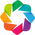

Set denDims={'JM': ['J', 'M'], 'JpMp': ['Jp', 'Mp']}. Pass directly for more control.
Set sphDims={'KQ': ['K', 'Q']}. Pass directly for more control.
['J', 'Jp']
['M', 'Mp']
['J', 'Jp', 'K', 'M', 'Mp', 'Q']


<xarray.DataArray '131Xe' (K: 2, Q: 1, t: 97, JM: 15, JpMp: 15)>
array([[[[[nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, 0.1924500897298752+/-0, ...,
           nan+/-nan, nan+/-nan, nan+/-nan],
          ...,
          [nan+/-nan, nan+/-nan, nan+/-nan, ...,
           0.08606629658238701+/-0, nan+/-nan, nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan]],

         [[nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, 0.1924500897298752+/-0, ...,
           nan+/-nan, nan+/-nan, nan+/-nan],
...
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan]],

         [[nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ...,
           -0.19764190292954284+/-0.012139664706313237, nan+/-nan,
           nan+/-nan],
          ...,
          [nan+/-nan, nan+/-nan,
           -0.19764190292954284+/-0.012139664706313237, ...,
           0.1056440408617689+/-0.006488923731619406, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan],
          [nan+/-nan, nan+/-nan, nan+/-nan, ..., nan+/-nan, nan+/-nan,
           nan+/-nan]]]]], dtype=object)
Coordinates:
  * K        (K) int64 0 2
  * Q        (Q) int64 0
  * t        (t) float64 -70.0 -60.0 -50.0 -40.0 ... 860.0 870.0 880.0 890.0
  * JM       (JM) MultiIndex
  - J        (JM) int64 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2
  - M        (JM) int64 2 1 0 -1 -2 2 1 0 -1 -2 2 1 0 -1 -2
  * JpMp     (JpMp) MultiIndex
  - Jp       (JpMp) int64 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2
  - Mp       (JpMp) int64 -2 -1 0 1 2 -2 -1 0 1 2 -2 -1 0 1 2
Attributes:
    dataType:       Density Matrix
    long_name:      Density Matrix
    units:          arb
    harmonics:      {'dtype': 'Complex harmonics', 'kind': 'complex', 'normTy...
    abundance:      0.212324+/-0.000030
    states:         {'JFlist': array([[1, 1.5, 1.5, 1.6903362694929476e-24+/-...
    uncertainties:  True
    density:        {'denDims': {'JM': ['J', 'M'], 'JpMp': ['Jp', 'Mp']}, 'sp...

In [3]:
# PKG version 23/07/24
from epsproc.calc.density import densityFromSphTensor

# isoKey = '129Xe'
isoKey = '131Xe'
TKQ = calcDict['modelDict'][isoKey].copy()

TKQ = TKQ.rename({'TKQ':'KQ'})
# TKQ

# tensorIn = TKQ.copy()
# tensorIn = checkSphDims(tensorIn, keyDims=listFuncs.getRefDims(tensorIn))
# sphDims = tensorIn.attrs['harmonics']['keyDims']

pmmPkg = densityFromSphTensor(TKQ)
# pmmPkg.name = 'Density Matrix'
# tensorIn
pmmPkg

In [4]:
pmmPkgDS = splitUncertaintiesToDataset(pmmPkg)
# pmmDS

# Plot lmplot style
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(pmmDS['denMat'], xDim=xDim, pType = 'r')

# pmm style with HVplot routine (note may be slow for many t-steps)
from epsproc.calc import density
density.matPlot(pmmPkgDS[isoKey].sel({'t':slice(0,200,2)}), kdims=['JM','JpMp'])

:HoloMap   [K,Q,t,pType]
   :HeatMap   [JM,JpMp]   (131Xe)

## Ionization model

## Compute gammas

For the full model, including spin, this currently requires two steps:

1. Compute spin decoupling, which decouples $J_{+}$ and $N_{+}$. This is the final two 3j terms in Eq. {eq}`eq:geom-params-C`.
2. Compute $\gamma$ parameters, this requires the spin weightings and density matrix for the excited state. This computes the remaining terms in Eq. {eq}`eq:geom-params-C`.

Eq. {eq}`eq:geom-params-C`
[SHOULD REF EQN. in 4.04 here - need to check syntax etc.]

In [5]:
# Compute spin decoupling
from epsproc.geomFunc.gamma import gammaCalc

JFlist = calcDict['modelDict'][isoKey].attrs['states']['JFlist']
Jf = JFlist[0][1]   # Final state J

# Compute spin weightings for given Jf case (==Jc in function).
spinDict = gammaCalc.spinWeightings(selectors={'Jc':Jf})

*** w3jTable: Setting backend='sympy' for 1/2-int 3j support.


/home/jovyan/code-share/github-share/ePSproc/epsproc/geomFunc/gamma/gammaCalc.py:793: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfprodSpin.index.set_levels(-1*dfprodSpin.index.levels[dfprodSpin.index.names.index(level)].values, level=level, inplace=True)
/home/jovyan/code-share/github-share/ePSproc/epsproc/geomFunc/gamma/gammaCalc.py:793: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfprodSpin.index.set_levels(-1*dfprodSpin.index.levels[dfprodSpin.index.names.index(level)].values, level=level, inplace=True)


In [6]:
# This will give all allowed Nc terms and spin weightings, for the LF and MF terms, and the product.
# Nc = Jc +/- S
# The output contains various parameter sets in a dictionary.
print(spinDict.keys())
print("Example for summed terms (first 20 lines only)...")
spinDict['sum'][0:20]

dict_keys(['sum', 'sub', 'full', 'coherentSq', 'coherentSqSum', 'sumTerms', 'sumTerms2', 'LFspinTerms', 'MFspinTerms', 'coherentTerms'])
Example for summed terms (first 20 lines only)...


LFspin    MFspin      prod
Nc  Kc   Mc                                
1.0 -1.0 -1.0 -0.422650 -0.422650  0.044658
          0.0  0.000000 -0.422650  0.000000
          1.0  0.422650 -0.422650 -0.044658
     0.0 -1.0 -0.422650  0.000000  0.000000
          0.0  0.000000  0.000000  0.000000
          1.0  0.422650  0.000000  0.000000
     1.0 -1.0 -0.422650  0.422650 -0.044658
          0.0  0.000000  0.422650  0.000000
          1.0  0.422650  0.422650  0.044658
2.0 -2.0 -2.0 -0.447214 -0.447214  0.200000
         -1.0  0.610905 -0.894427 -0.273205
          0.0 -0.632456 -0.894427  0.282843
          1.0  0.610905 -0.894427 -0.273205
          2.0 -0.447214 -0.447214  0.200000
    -1.0 -2.0 -0.894427  0.610905 -0.273205
         -1.0  1.221810  1.221810  0.373205
          0.0 -1.264911  1.221810 -0.386370
          1.0  1.221810  1.221810  0.373205
          2.0 -0.894427  0.610905 -0.273205
     0.0 -2.0 -0.894427 -0.632456  0.282843

In [7]:
# Compute gamma parameters
from epsproc.geomFunc.gamma import gammaCalc
# pd.set_option('display.max_rows', 1000)

# isoKey = '131Xe'  # Note this is already set at den mat stage above
# pmmPkgDS = splitUncertaintiesToDataset(pmmPkg)

# Subselect and sum
Ji = int(JFlist[0][0]) # Initial state J
# Set terms for legacy code
J = Ji
Jp = Ji

pmmSub = pmmPkgDS[isoKey].sel({'J':J,'Jp':Jp})  #.sum(['K','Q'])

# pmmSub = pmmPkgDS[isoKey]

# Pre-calc C terms (optional)
# Set allowed terms for channels, [Ni,Ki,Nf,Kf]. Note these are for Ni,Nf in gammaCalc!
# For Xe, Ji == Ni, and Nf can take multiple allowed values.
# channel = [Ji,None,Nf,None]  # Defined Ni, Nf, all Ki,Kf
channel = [Ji,None,None,None]  # Set to None for all Nf
Cterms = gammaCalc.Ccalc(channel)

# Calc gamma 
gammaPmm, lPhase, Cpmm, Cterms = gammaCalc.gammaCalc(Cterms = Cterms, denMat=pmmSub,
                                                     spinWeightings=spinDict,
                                                     sumList = ['q','qp','Mi','Mip','Nt','Ntp','Mt','Mtp','Mc','Nc'])

# gammaPmm[0:100]

## Compute betas

### Arb. mat E test

Quick function test using randomly assigned matrix elements.

In [8]:
# 12/08/24 update - now with pkg versions... OK for test case

# Functionalised plotter OK
from epsproc.geomFunc.gamma import gammaPlot

betaOut, betaOutNorm = gammaCalc.betaCalc(gammaPmm)
# BLMplot(betaXRremapped, backend='hv', xDim='t', thres=None,) 

gammaPlot.betaCalcPlot(betaOutNorm, thres = 1e-1, pType='a')  # Abs values
# gammaPlot.betaCalcPlot(betaOut, thres = 5e-1, pType='r')  # Real values

:NdOverlay   [Variable]
   :Curve   [t]   (value)

In [9]:
# # Optional - push results to ePSproc class for additional plotters etc.

# from epsproc.geomFunc.gamma.gammaIO import toePSprocClass

# dataConv = toePSprocClass(betaOutNorm)  #, dataType='AFBLM')

# dataConv.BLMplot(xDim='t', backend='hv', hvType='line')  #, dataType='BLM')

### Application to Xe case

- Set per $J_{+}$.
- Symmetry allowed matrix elements, but arb values.

In [14]:
# from epsproc.geomFunc.gamma import gammaCalc
# pd.set_option('display.max_rows', 1000)
# %load_ext autoreload
# %autoreload 2

# from epsproc.geomFunc.gamma import gammaCalc

# Set matE (from above/below)
matEXe = matEInputCleanM0 # matEinput, matEinputM0, matEInputClean, matEInputCleanM0
betaJ = {}

# Set state
# TODO: need to update Jf lists 
isoKey = '131Xe'
Jilist = calcDict['modelDict'][isoKey].attrs['states']['JFlist']
# Jf = JFlist[0][1]   # Final state J
JFlist = [0.5,1.5]  # Set manually for multiple Jf case!

# Loop over keys and calculate...
for Jf in JFlist:

    ## Spin weighting per Jf
    # Jf = 0.5

    # Compute spin weightings for given Jf case (==Jc in function).
    spinDict = gammaCalc.spinWeightings(selectors={'Jc':Jf})


    # Subselect and sum
    # Subselect and sum
    Ji = int(Jilist[0][0]) # Initial state J
    # Set terms for legacy code
    J = Ji
    Jp = Ji

    pmmSub = pmmPkgDS[isoKey].sel({'J':J,'Jp':Jp})  #.sum(['K','Q'])

    # Calc Cterms
    # 29/11/24 - allow multiple Jf/Nc for spin case. Set Jf=None for this case.
    #          - Add Nc to sumList
    channel = [J,None,None,None]
    Cterms = gammaCalc.Ccalc(channel, spinWeightings=spinDict, thres=1e-4)

    # Calc gamma 
    gammaPmm, lPhase, Cpmm, Cterms = gammaCalc.gammaCalc(Cterms = Cterms, denMat=pmmSub,)
                                                         # sumList = ['q','qp','Mi','Mip','Nt','Ntp','Mt','Mtp','Mc','Nc'])

    # Calc betas
    betaOut, betaOutNorm = gammaCalc.betaCalc(gammaPmm, matE=matEXe,
                                          channel = channel) #, thres=1e-6) 
                                          # cols=['l','m','matE1'])  # Cols currently hard-coded in betaCalc
                                            # cols=['l','lam','matE1'])
    # BLMplot(betaXRremapped, backend='hv', xDim='t', thres=None,) 

    # VERSION with full var return for testing
    # betaCalcFull = gammaCalc.betaCalc(gammaPmm, matE=matEInputCleanMod,
    #                                           channel = [J,None,None,None], returnType='full') #, thres=1e-6) 
    
    # Assign results to dict
    betaJ[Jf] = {'betaOut': betaOut, 
              'betaNorm':betaOutNorm,
              'Jf':Jf,
              'isoKey':isoKey,
              'spinW':spinDict,
              'gammaOut':(gammaPmm, lPhase, Cpmm, Cterms)}

*** w3jTable: Setting backend='sympy' for 1/2-int 3j support.


/home/jovyan/code-share/github-share/ePSproc/epsproc/geomFunc/gamma/gammaCalc.py:793: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfprodSpin.index.set_levels(-1*dfprodSpin.index.levels[dfprodSpin.index.names.index(level)].values, level=level, inplace=True)
/home/jovyan/code-share/github-share/ePSproc/epsproc/geomFunc/gamma/gammaCalc.py:793: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfprodSpin.index.set_levels(-1*dfprodSpin.index.levels[dfprodSpin.index.names.index(level)].values, level=level, inplace=True)


*** w3jTable: Setting backend='sympy' for 1/2-int 3j support.


/home/jovyan/code-share/github-share/ePSproc/epsproc/geomFunc/gamma/gammaCalc.py:793: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfprodSpin.index.set_levels(-1*dfprodSpin.index.levels[dfprodSpin.index.names.index(level)].values, level=level, inplace=True)
/home/jovyan/code-share/github-share/ePSproc/epsproc/geomFunc/gamma/gammaCalc.py:793: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfprodSpin.index.set_levels(-1*dfprodSpin.index.levels[dfprodSpin.index.names.index(level)].values, level=level, inplace=True)


In [15]:
# Comparison plots

(gammaPlot.betaCalcPlot(betaJ[0.5]['betaNorm'], thres = 1e-1, pType='a') + 
 gammaPlot.betaCalcPlot(betaJ[1.5]['betaNorm'], thres = 1e-1, pType='a')).cols(1)

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [t]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [t]   (value)

In [16]:
# Alternative plot - unnormalised values.
(gammaPlot.betaCalcPlot(betaJ[0.5]['betaOut'], thres = 1e-4, pType='r') + 
 gammaPlot.betaCalcPlot(betaJ[1.5]['betaOut'], thres = 1e-5, pType='r')).cols(1)

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [t]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [t]   (value)

Testing notes...

- matEinputM0, 131Xe.
    - Anti-phased results, good.
    - B00 +ve for all times and Jf
    - B20 too large for Jf=1.5 case, but will depend on matrix elements of course.
- matEinput, 131Xe.
    - As above, but also get M!=0 terms.
    - Either indicates matrix elements not correctly set, or shouldn't have mu!=0 terms?
    - For atomic case SHOULD have these terms, but will cancel out? Or effectively only address M=0 due to alignment?
- matEInputClean, 131Xe
    - Case for no mu. Have M=0,2 terms here.
    - Phase relations seem correct.
- matEInputCleanM0, 131Xe
    - Similar to matEinputM0 case at a glance.


In [ ]:
betaJ[0.5]['betaOut']

In [ ]:
# Clean up coords.
# See also ep.sphFuncs.sphConv.cleanLMcoords()
# But Xarray only
# https://github.com/phockett/ePSproc/blob/fda95cd693085d8161794bdac04dc5a7cfb5db1f/epsproc/sphFuncs/sphConv.py#L626

# For PD, https://stackoverflow.com/questions/29150346/pandas-modify-a-particular-level-of-multiindex
df = betaJ[0.5]['betaOut']

levelName = 'M'
df.index = df.index.set_levels(
                    df.index.levels[df.index.names.index(levelName)].astype(int),
                    level = levelName
            )

In [ ]:
betaJ[0.5]['gammaOut'][3]

In [ ]:
break

**TESTING NOTES BELOW - need cleaning up**

---

### Manual configuration - set two energies and per symmetrized case, but all mu

From v1 notebook, http://jake:9988/lab/tree/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/notebooks/4_modelling/4.04_Xe_ionization_model_300624.ipynb

Update to test/use state-selected code.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
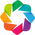

*** Mapping coeffs to ePSproc dataType = matE
Remapped dims: {}
Added dim Cont
Added dim Targ
Added dim Total
Added dim it
Added dim Type


Eke                                      0         1
Cont Targ Total Type it  l m  mu                    
U    U    U     U    NaN 1 -1 -1 -0.353553 -0.707107
                               1 -0.353553 -0.707107
                            0  0  0.500000  1.000000
                            1 -1 -0.353553 -0.707107
                               1 -0.353553 -0.707107
                         3 -1 -1 -0.353553 -0.707107
                               1 -0.353553 -0.707107
                            0  0  0.500000  1.000000
                            1 -1 -0.353553 -0.707107
                               1 -0.353553 -0.707107

In [11]:
# Manual configuration of matrix elements
# Example using data class
from pemtk.fit.fitClass import pemtkFit
dataManual = pemtkFit()

# Manual setting for matrix elements
# See API docs at https://epsproc.readthedocs.io/en/dev/modules/epsproc.util.setMatE.html
EPoints = 2

# Test case
# dataManual.setMatE(data = [[0,0, *np.ones(EPoints)], [2,0, *np.linspace(0,1,EPoints)], [4,0, *np.linspace(0,0.5,EPoints)]], 
#              dataNames=['l','m'], conformDims=True)

# Try for T1u case...
# dataManual.setMatE(data = [[1,0,0, *np.ones(EPoints)], 
#                            [1,1,1, *(np.ones(EPoints)*(-1/np.sqrt(2)))],
#                            [1,1,-1, *(np.ones(EPoints)*(-1/np.sqrt(2)))],
#                            [1,-1,1, *(np.ones(EPoints)*(-1/np.sqrt(2)))],
#                            [1,-1,-1, *(np.ones(EPoints)*(-1/np.sqrt(2)))],
#                           ], 
#              dataNames=['l','m','mu'], conformDims=True)

# With modified magnitudes...
# NOTE: this is normalised out in BLM calcs, aside from overall XS
# dataManual.setMatE(data = [[1,0,0, *np.linspace(0.5,1,EPoints)], 
#                            [1,1,1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
#                            [1,1,-1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
#                            [1,-1,1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
#                            [1,-1,-1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
#                           ], 
#              dataNames=['l','m','mu'], conformDims=True)


# Add l=3 terms...
# NOTE phases not set carefully here, just testing lmax effects.
# NOTE: relative magnitudes are normalised out in BLM calcs, aside from overall XS
# NOTE: didn't try setting additional phases here as yet!
dataManual.setMatE(data = [[1,0,0, *np.linspace(0.5,1,EPoints)], 
                           [1,1,1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [1,1,-1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [1,-1,1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [1,-1,-1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [3,0,0, *np.linspace(0.5,1,EPoints)], 
                           [3,1,1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [3,1,-1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [3,-1,1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                           [3,-1,-1, *(np.linspace(0.5,1,EPoints)*(-1/np.sqrt(2)))],
                          ], 
             dataNames=['l','m','mu'], conformDims=True)


# Matrix elements are set to Xarray and Pandas formats, under the 'matE' key
dataManual.data['matE']['matE'].pd

In [12]:
# # 14/08/24: test state-selected code with these matrix elements...

# # Functionalised plotter OK
# from epsproc.geomFunc.gamma import gammaPlot, gammaCalc

# betaOut, betaOutNorm = gammaCalc.betaCalc(gammaPmm, matE=dataManual.data['matE']['matE'].pd)
# # BLMplot(betaXRremapped, backend='hv', xDim='t', thres=None,) 

# gammaPlot.betaCalcPlot(betaOutNorm, thres = 1e-1, pType='a')

In [13]:
# Currently may need to reformat matE...
# Single Eke only?
# ALSO NEED TO USE OR DROP mu here...
# TODO - test further and simplify/wrap as required.

matEinput = dataManual.data['matE']['matE'].pd[0].to_frame()
matEinput.rename(columns={0:'matE1'}, inplace=True)
matEinput = matEinput.droplevel(['Cont','Targ','Total','Type','it'])

# DROP MU - optional
df = matEinput.droplevel('mu')
# matE1.drop_duplicates()   # Drop l=3 terms...? Check code elsewhere for solution here...
matEInputClean = df[~df.index.duplicated()]  # Ah, drop duplicated INDEX items
# dfClean

# MOD TERMS - optional
# Subselect m=0 only
matEinputM0 = matEinput.xs(key=0,level='m', drop_level=False)
matEInputCleanM0 = matEInputClean.xs(key=0,level='m', drop_level=False)

# TEST MATE assignments only.
dfCalc, matE1, matE2 = gammaCalc.assignMatE(gammaPmm, matE=matEinputM0,       # matE=matEInputCleanMod, 
                                            cols=['l','m','matE1'], colsPrime=['lp','mp','matE2'])

                                            # cols=['l','lam','matE1'], colsPrime=['lp','lamp','matE2'])
matE1

,,,matE1
l,m,mu,
1,0,0,0.5
3,0,0,0.5


In [ ]:
# matE2

In [ ]:
# matEinput

In [ ]:
# # TODO: work out where all the NaNs come from...!
# # Issue with matE assignment, or phases in ang mom calcs?
# # Could also be issue with m/lam mix-up and betaTerm...?
# dfCalc

In [ ]:
# dfCalc.xs(key=0, level='Kt').max()
# dfCalc.max(axis=0)

In [ ]:
# CALC WITH CLEANED UP MATE
# 14/08/24 - RUNS, but looks like all NaN output on first test...?
# 23/08/24 added dropna option here. For cases with NaN matE, skipping this may lead to all-NaN outputs.
#          TODO: more checks/tests here, haven't carefully verified drop is OK.
#          UPDATE: Now working, but plotter borked...? TBC
#          UPDATE: OK after a page refresh!!!

betaOut, betaOutNorm = gammaCalc.betaCalc(gammaPmm, matE=matEinputM0)  #matEInputCleanMod,) 
                                          # cols=['l','m','matE1'])  # Cols currently hard-coded in betaCalc
                                            # cols=['l','lam','matE1'])
# BLMplot(betaXRremapped, backend='hv', xDim='t', thres=None,) 

gammaPlot.betaCalcPlot(betaOutNorm, thres = None, pType='a')

In [ ]:
betaOutNorm

In [ ]:
break

In [ ]:
# Check unnorm values - note that B00 should be +ve if physically valid terms have been set.
betaOut

In [ ]:
# Check all locals()....

bClocals = gammaCalc.betaCalc(gammaPmm, matE=matEInputCleanMod,returnType='full') 
bClocals.keys()

In [ ]:
# AH - have 2 kinds of NaNs here, plus some non-zero terms... maybe the issue?
# for row> 500, have N00000000a00000000N
# for row< 500, have NaN
# Non-zero terms [540:675]
# Issue with source of Nans...?
# UPDATE: looks like a rendering thing... if no non-NaN terms, display as "NaN", otherwise render differently!

pd.set_option('display.max_rows', 500)
bClocals['dfMult'].xs(key=1,level='l').xs(key=1,level='lp')[540:675]   #.xs(key=0,level='m').xs(key=1,level='l').xs(key=1,level='lp')[0:100]  #.max()

In [ ]:
# bClocals['dfMult'].xs(key=1,level='l').xs(key=1,level='lp')[500:520].isna()  # OK
bClocals['dfMult'].xs(key=1,level='l').xs(key=1,level='lp')[500:600].isna()  # OK

In [ ]:
# 19/08/24 ******HERE****** Seems that sum over NaNs is the issue here.
#  TODO: correct clean-up/drop method.
#
# This seems to kill non-NaN terms...?
# BLMprod = bClocals['dfMult'].merge(bClocals['betaTerm'], 
#          left_index=True, 
#          right_index=True,
#          how='left')       # Use index from gamma/dfMult as primary.

dfMultTest = bClocals['dfMult'].dropna(how='all')   # AH - seems OK with drop NaN, but should confirm this is not dropping real terms!
BLMprod = dfMultTest.merge(bClocals['betaTerm'], 
         left_index=True, 
         right_index=True,
         how='left')       # Use index from gamma/dfMult as primary.

sumTerms = BLMprod.iloc[:, :-1].mul(BLMprod['betaTerm'],axis=0) 
betaOut = sumTerms.groupby(by=['L','M']).sum()
betaOutNorm = betaOut/betaOut.loc[0,0]

betaOutNorm

In [ ]:
gammaPlot.betaCalcPlot(betaOutNorm, thres = 1e-1, pType='a')

In [ ]:
dfMultTest

In [ ]:
bClocals['BLMprod'].xs(key=1,level='l').xs(key=1,level='lp')[500:600]  #.isna()  # OK

In [ ]:
bClocals['betaTerm']

In [ ]:
dfCalc

In [ ]:
matEInputClean

In [ ]:
# df = matE1.droplevel('mu')
# # matE1.drop_duplicates()   # Drop l=3 terms...? Check code elsewhere for solution here...
# dfClean = df[~df.index.duplicated()]  # Ah, drop duplicated INDEX items
# dfClean

In [ ]:
# df = matE1.droplevel('mu')
# df[~df.index.duplicated()]

In [ ]:
# Check specific cases...
# pd.set_option('display.max_rows', None)
dfCalc.xs(key=0,level='m').xs(key=1,level='l').xs(key=1,level='lp')['matE1']   # [0.0]  #.max()

In [ ]:
matEinput.droplevel(['Cont','Targ','Total','Type','it'])

In [ ]:
matEtemplate = gammaCalc.setTestMatE(gammaPmm, cols=['l','lam','matE1'])
matEtemplate

In [ ]:
gammaPmm

In [ ]:
dataManual.data['matE']['matE'].pd[0].to_frame()